In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
TOP = 100
BOTTOM = 300
RIGHT = 150
LEFT = 350

In [4]:
ROOT = os.getcwd()
ROOT

'c:\\Users\\dell-2019\\Desktop\\Sign Language Detection'

Testing the image contouring
[Code reference](https://stackoverflow.com/a/65794671/13280114)

In [5]:
def segment_hand_simple(img):
    # define the upper and lower boundaries of the HSV pixel intensities 
    # to be considered 'skin'
    
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype="uint8") 
    upper = np.array([20, 255, 255], dtype="uint8")
    skinMask= cv.inRange(hsvim, lower, upper)

    # blur the mask to help remove noise
    skinMask= cv.blur(skinMask, (2, 2))

    # get threshold image
    ret, thresh = cv.threshold(skinMask, 100, 255, cv.THRESH_BINARY)
    return thresh

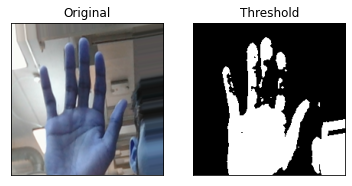

In [6]:
img_path = "images/train/f/sampled-1.png"
img = cv.imread(img_path)

thresh = segment_hand_simple(img)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(thresh)
ax[0].set_title("Original")
ax[1].set_title("Threshold")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.imshow(thresh, cmap='gray')

The ``generate_images()`` function is used to make augmented copies of the captured frame. This populates the dataset with a broad range of images to learn from.

In [7]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# generates transformed images for more data
def generate_images(img, prefix='sampled'):
    # creates a data generator object that transforms images
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest')
    try:
        # pick an image to transform
        img = image.img_to_array(img)  # convert image to numpy array
        img = img.reshape((1,) + img.shape)  # reshape image
        i = 0
        # this loops runs forever until we break, saving images to current directory with specified prefix
        for batch in datagen.flow(img, save_prefix=prefix, save_format='png'):
            # plt.figure(i)
            # plot = plt.imshow(image.img_to_array(batch[0]))
            cv.imwrite(f'{prefix}-{i}.png', image.img_to_array(batch[0]))
            i += 1
            if i > 4:  # 4 images
                break
        plt.show()
    except Exception as e:
        print(f"[ERROR]  {e}")

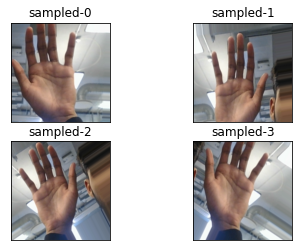

In [8]:
# os.chdir(ROOT)

'''
Example of how the images are generated
create a subplot of all the generated images
'''
fig, ax = plt.subplots(2, 2)
images = [image.load_img(f'images/train/f/sampled-{i}.png') for i in range(4)]
for i, img in enumerate(images):
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].set_xticks([])
    ax[i // 2, i % 2].set_yticks([])
    ax[i // 2, i % 2].set_title(f'sampled-{i}')

In [9]:
def chdir(path):
    if os.path.exists(f'images/{path}'):
        print('Directory changed to images')
    else:
        print('Directory not found')
        os.mkdir(f'images/{path}')
    os.chdir(f'images/{path}')

Here we begin collecting the images using OpenCV.<br>
Using the functions created above, we augument and segment the collected images.

In [39]:
# the letter of the hand
index = 'z'

# change directory to the folder where the images are
if os.getcwd() == ROOT:
    chdir(f"train/{index}")
else: 
    os.chdir(ROOT)
    chdir(f"train/{index}")

cam = cv.VideoCapture(0)
img_counter = 0

while True:
    ret, frame = cam.read()
    # filpping the frame to prevent inverted image of captured frame
    frame = cv.flip(frame, 1)
    
    if not ret:
        print("Please check if the camera is connected properly or is being used by another program")
        break

    
    # Drawing ROI on frame copy
    cv.imshow("Frame", frame)

    frame_copy = frame.copy()
    roi = frame[TOP:BOTTOM, RIGHT:LEFT]

    k = cv.waitKey(1)
    if k%256 == 27:
        break
    elif k%256 == 32: # SPACE pressed
        hand = roi#segment_hand_simple(roi)
        img_name = "{}.png".format(img_counter)
        path = os.getcwd() # get current working directory

        # save the image
        cv.imwrite(os.path.join(path , img_name), hand)

        # generate more images for the dataset
        generate_images(hand, f"sampled-{img_counter}")

        # increment the image counter
        img_counter += 1
        if img_counter == 6:
            break

    # Display the frame with segmented hand
    cv.rectangle(frame_copy, (LEFT, TOP), (RIGHT, BOTTOM), (255,128,0), 3)

    cv.imshow("Hand Region", roi)

cam.release()
cv.destroyAllWindows()
# change directory to the root directory
os.chdir(ROOT)

Directory not found


1. Load the images using Keras ImageDataGenerator
    - ImageDataGenerator is a high-level class that allows to yield data from multiple sources (from np arrays, from directories...) and that includes utility functions to perform image augmentation et cetera.
<br>
<br>
2. Create a normalization layer to standardize the data
<br>
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.
<br>
Therefore we standardize values to be in the [0, 1] range by using `rescale=(1./255)`

[Code Reference](https://www.tensorflow.org/tutorials/images/classification)

In [40]:
train_path = os.path.join(ROOT, "images/train")
test_path = os.path.join(ROOT, "images/test")

params = {
    'preprocessing_function': tf.keras.applications.vgg16.preprocess_input,
    'shear_range':0.2,
    'zoom_range':0.2,
    'horizontal_flip':False,
    'rescale':1./255,
}

train_batches = ImageDataGenerator(**params)

train_data = train_batches.flow_from_directory(
    directory=train_path, 
    target_size=(64,64), 
    class_mode='categorical', 
    batch_size=16,
    shuffle=True
)

Found 989 images belonging to 26 classes.


In [41]:
image_batch, labels_batch = next(train_data)
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]` and not `[0,255]`.
print(np.min(first_image), np.max(first_image))

-0.35814512 0.3118272


In [74]:
CLASSES = {v: k for k, v in train_data.class_indices.items()}
train_data.image_shape, CLASSES

((64, 64, 3),
 {0: 'a',
  1: 'b',
  2: 'c',
  3: 'd',
  4: 'e',
  5: 'f',
  6: 'g',
  7: 'h',
  8: 'i',
  9: 'j',
  10: 'k',
  11: 'l',
  12: 'm',
  13: 'n',
  14: 'o',
  15: 'p',
  16: 'q',
  17: 'r',
  18: 's',
  19: 't',
  20: 'u',
  21: 'v',
  22: 'w',
  23: 'x',
  24: 'y',
  25: 'z'})

In [ ]:
# plot the images

# MODEL CREATION

In [45]:
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam

In [46]:
INPUT_SHAPE = (64, 64, 3)
OUTPUT_SHAPE = train_data.num_classes

In [47]:
model_params = [
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(64,activation ="relu"),
    Dense(128,activation ="relu"),
    Dense(128,activation ="relu"),
    Dense(OUTPUT_SHAPE,activation ="softmax")
]

params = {
    'loss': 'categorical_crossentropy',
    'optimizer': Adam(learning_rate=0.001),
    'metrics': ['accuracy']
}

In [48]:
model = Sequential(model_params)

# compile the model with params
model.compile(**params)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

NOTE: You need to install [Graphviz](https://graphviz.org/download/) and `pydot` for the following cell to run

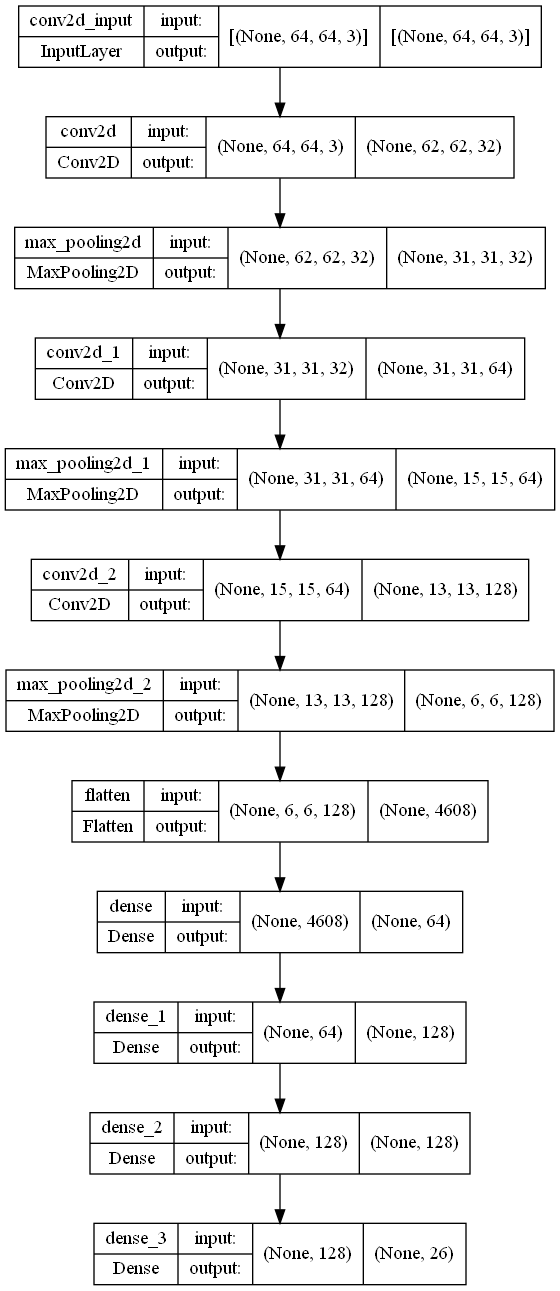

In [49]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [50]:
history = model.fit(train_data, epochs=50)

Epoch 1/50
62/62 [==============================] - 28s 407ms/step - loss: 3.1652 - accuracy: 0.0677
Epoch 2/50
62/62 [==============================] - 11s 177ms/step - loss: 2.7122 - accuracy: 0.1820
Epoch 3/50
62/62 [==============================] - 7s 119ms/step - loss: 2.3106 - accuracy: 0.2538
Epoch 4/50
62/62 [==============================] - 8s 134ms/step - loss: 2.0453 - accuracy: 0.3104
Epoch 5/50
62/62 [==============================] - 9s 149ms/step - loss: 1.8803 - accuracy: 0.3761
Epoch 6/50
62/62 [==============================] - 8s 129ms/step - loss: 1.5939 - accuracy: 0.4722
Epoch 7/50
62/62 [==============================] - 9s 148ms/step - loss: 1.3944 - accuracy: 0.5187
Epoch 8/50
62/62 [==============================] - 10s 161ms/step - loss: 1.1986 - accuracy: 0.5895
Epoch 9/50
62/62 [==============================] - 9s 141ms/step - loss: 0.9692 - accuracy: 0.6734
Epoch 10/50
62/62 [==============================] - 9s 141ms/step - loss: 0.9032 - accuracy: 0.6

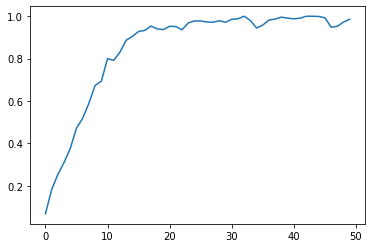

In [51]:
# plot the training loss and accuracy
plt.plot(history.history['accuracy'])

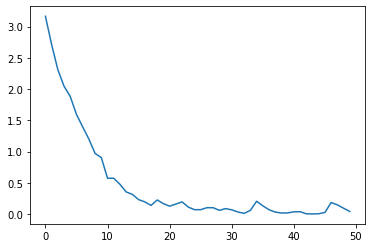

In [52]:
plt.plot(history.history['loss'])

In [ ]:
# prepare the test data
from random import sample

os.chdir(ROOT)


for letter in CLASSES.keys():
    path = f"images/test/{letter}/"
    print(path)
    files = os.listdir(path)
    for file in sample(files,8):
        os.remove(path+file)

In [148]:
# load the test data
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_data = test_batches.flow_from_directory(
    directory=test_path,
    target_size=(64,64),
    class_mode='categorical',
    # batch_size=16,
    shuffle=True
)

imgs, labels = next(test_data)

Found 495 images belonging to 26 classes.


In [156]:
scores = model.evaluate(imgs, labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100, '%')

1/1 [==============================] - 1s 679ms/step - loss: 62.0984 - accuracy: 0.9062
Test loss: 62.098388671875
Test accuracy: 90.625 %


In [150]:
imgs.shape

(32, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


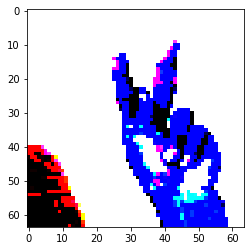

In [151]:
plt.imshow(imgs[0], cmap='gray')

In [152]:
try:
    predictions = model.predict(imgs)
    predictions
except Exception as e:
    print(e.__context__)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: k; Actual: k


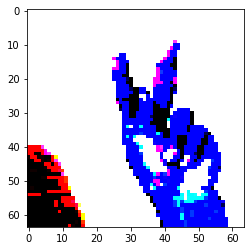

In [153]:
# loop through the test data and print the prediction and the actual label
plt.imshow(imgs[0])
print(f'Prediction: {CLASSES[predictions[0].argmax()]}; Actual: {CLASSES[labels.argmax()]}')

In [154]:
def make_predictions(model, test_batches):
    imgs, labels = next(test_batches)
    predictions = model.predict(imgs)
    return predictions, labels, imgs[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: n; Actual: n


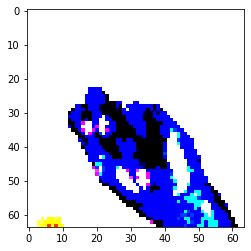

In [155]:
pred, true, img = make_predictions(model, test_data)

plt.imshow(img)
print(f'Prediction: {CLASSES[pred[0].argmax()]}; Actual: {CLASSES[true.argmax()]}')

Save the model

In [157]:
model.save('vgg16-90.h5')

Evaluate the model

In [ ]:
# check the accuracy of the model
from termcolor import colored

batch = 20
loss = 0

if batch > len(test_batches):
    print(f"Batch size is greater than the test data size.\nBatch size : {batch}\nTest data size : {len(X_test)}")
    batch = 10

for i in range(batch):
    prediction = model.predict(np.array([X_test[i]]))
    # print(CLASSES[np.argmax(prediction)], "->", CLASSES[np.argmax(y_test[i])])
    predicted_class, actual_class = CLASSES[np.argmax(prediction)], CLASSES[np.argmax(y_test[i])]

    # checks for the classes and sets color's depending on that
    color = 'green' if predicted_class == actual_class else 'red'
    if color == 'red': loss += 1
    print(colored(f'[{i}] Predicted : {predicted_class : <2}|  Expected : {actual_class}', color))

perc = round(100/(batch/(batch-loss)), 3)
print(f"Accuracy {perc}%\nLoss : {100-perc}%")